# Categorizing metallicity

In [1]:
%matplotlib inline

from fastai import *
from fastai.vision import *

from IPython.display import display
PATH = os.path.abspath('../..')

seed = 12345

# Round data and make into categories

In [6]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)
df.sample(10)

,objID,oh_p50
17102,1237667254526608012,8.603400
41805,1237651250405310707,9.046176
32631,1237661976547623011,9.130574
83345,1237658492259860686,9.142964
40820,1237651754563141950,8.569036
47433,1237653589019066631,8.813934
37527,1237657634334507068,9.010649
31384,1237674649391661241,8.933505
31931,1237667211584143479,9.128632
85434,1237664667353088124,8.868751


In [7]:
# round to nearest 0.02
df.oh_p50 = (df.oh_p50 / 2).round(decimals=2) * 2
df.oh_p50.sample(10)

24578    8.96
37321    9.14
63708    8.60
3883     9.08
94848    8.38
19734    8.94
94787    8.94
71059    8.90
67039    8.94
94568    8.76
Name: oh_p50, dtype: float64

In [8]:
bs = 128
sz = 128

tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.15, p_lighting=0)

data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', 
                       label_cls=CategoryList) # categorize
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

/home/johnwu/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:519: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
9.44, 7.98
  if getattr(ds, 'warn', False): warn(ds.warn)


# Train (resnet34)

In [9]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


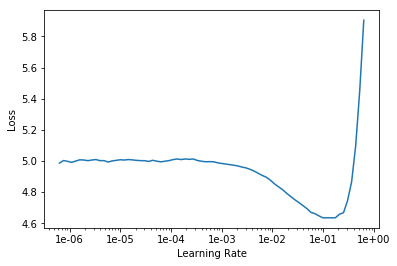

In [10]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,time
0,2.892738,3.183611,00:52


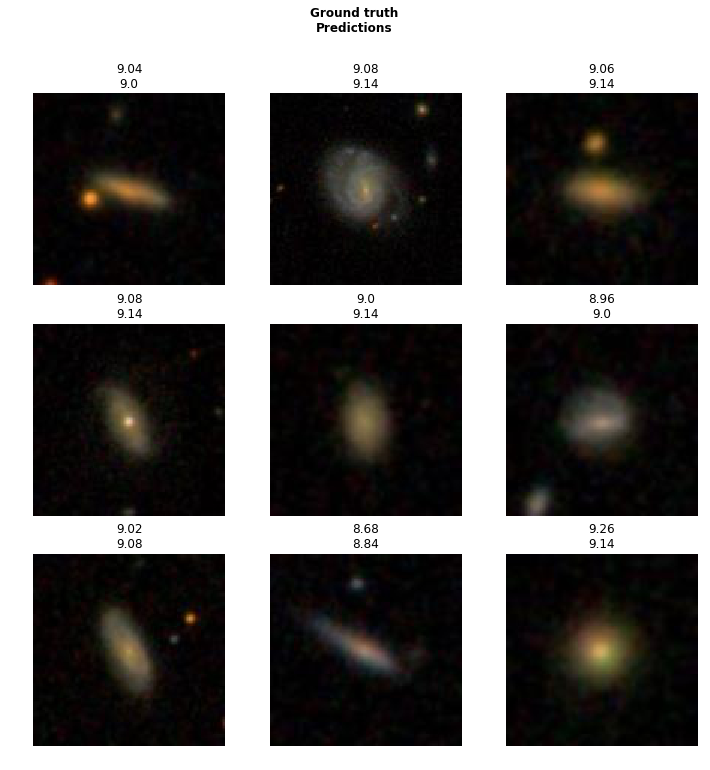

In [13]:
learn.show_results(3, 3)

In [15]:
interp = learn.interpret()

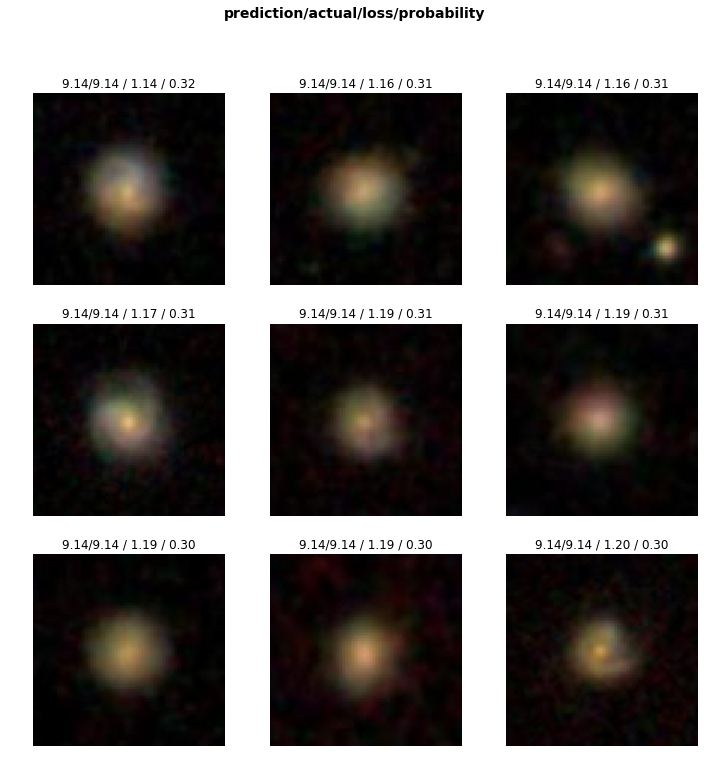

In [29]:
# most accurate
interp.plot_top_losses(9, largest=False, heatmap=False)

# More train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


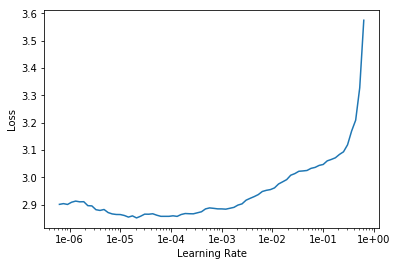

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,time
0,2.798071,2.734058,01:11
1,2.771723,2.763229,01:11
2,2.773604,2.715251,01:11
3,2.753678,2.720114,01:11
4,2.722781,2.687775,01:12
5,2.723632,2.677300,01:11
6,2.698172,2.672293,01:11
7,2.700179,2.664847,01:11
8,2.680212,2.647699,01:11
9,2.689671,2.653313,01:11


# Interpret

In [33]:
interp = learn.interpret(tta=True)

Text(0, 0.5, 'Truth')

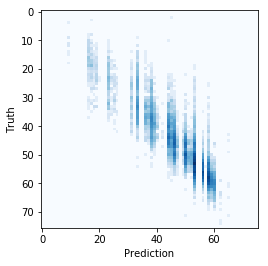

In [34]:
cm = interp.confusion_matrix()

plt.imshow(np.log10(1+cm), cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')

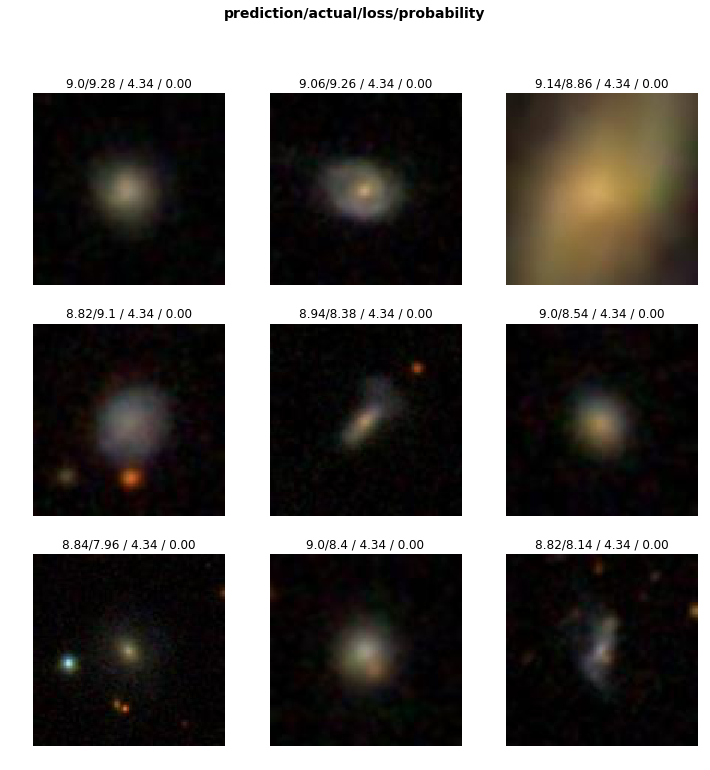

In [36]:
interp.plot_top_losses(9, largest=True, heatmap=False)

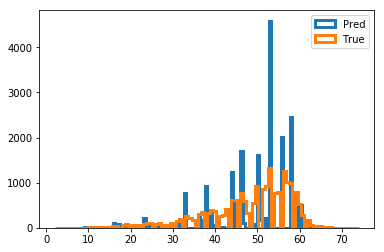

In [58]:
plt.hist(interp.pred_class, bins=100, histtype='step', label='Pred', lw=3)
plt.hist(interp.y_true, bins=100, histtype='step', label='True', lw=3)
plt.legend()

# Retrain (xresnet18)

In [61]:
learn = cnn_learner(data, base_arch=models.xresnet18, pretrained=False)

In [62]:
learn.fit_one_cycle(40, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,3.270862,3.047190,00:56
1,3.076622,2.959622,00:55
2,2.987393,2.936046,00:56
3,2.944749,2.874428,00:56
4,2.916348,2.840826,00:56
5,2.883259,2.808571,00:56
6,2.869457,2.791359,00:56
7,2.862678,2.786801,00:56
8,2.854573,2.955880,00:56
9,2.864227,2.845611,00:56


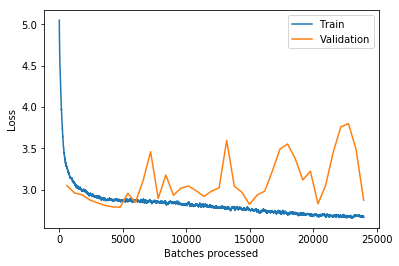

In [63]:
learn.recorder.plot_losses()

Re-interpret

In [64]:
interp = learn.interpret(tta=True)

Text(0, 0.5, 'Truth')

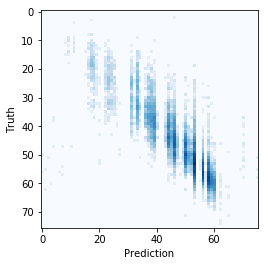

In [65]:
cm = interp.confusion_matrix()

plt.imshow(np.log10(1+cm), cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [68]:
interp.pred_class

tensor([47, 58, 31,  ..., 23, 53, 50])

# Verdict
Seems like predicting categories here does not help. The class imbalance isn't great, and it's probably worth noting that true metallicities are quite uncertain anyway.

# Broader classes

In [70]:
df = pd.read_csv(train_label_csv)
df.oh_p50 = (df.oh_p50 / 2).round(decimals=1) * 2
df.oh_p50.sample(5)

17102    8.6
41805    9.0
32631    9.2
83345    9.2
40820    8.6
Name: oh_p50, dtype: float64

In [71]:
data = (ImageList.from_df(path=PATH, 
                          df=df, 
                          folder='train',
                          cols='objID',
                          suffix='.jpg')
        .split_by_rand_pct(0.2, seed=seed)
        .label_from_df(cols='oh_p50', 
                       label_cls=CategoryList)
        .transform(tfms, size=sz)
        .databunch(bs=bs)
       )

In [72]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


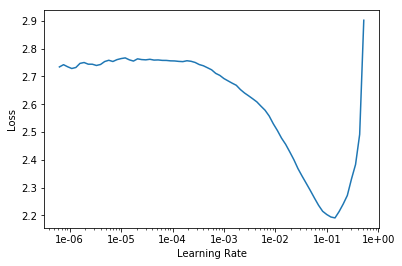

In [73]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


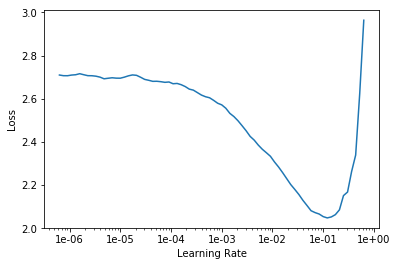

In [74]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(10, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,time
0,0.869306,0.845709,00:49
1,0.826720,0.798026,00:50
2,0.813542,0.874984,00:52
3,0.800315,0.755258,00:48
4,0.767375,0.732873,00:48
5,0.756557,0.727719,00:49
6,0.742583,0.717516,00:49
7,0.727673,0.698901,00:48
8,0.705289,0.694502,00:48
9,0.708188,0.691226,00:48


In [76]:
interp = learn.interpret(tta=True)

Text(0, 0.5, 'Truth')

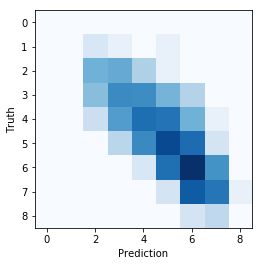

In [80]:
cm = interp.confusion_matrix()

plt.imshow(np.log10(1+cm), cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')

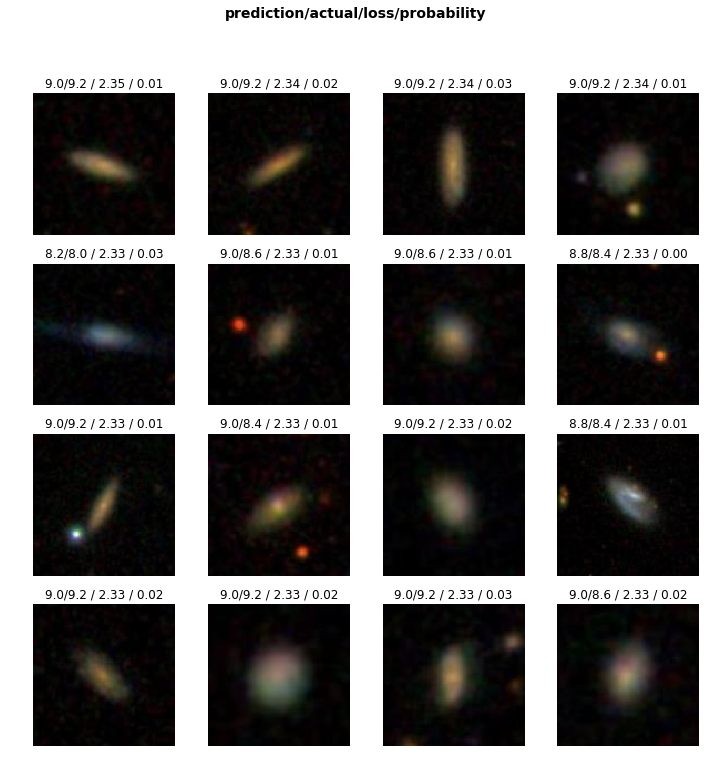

In [83]:
interp.plot_top_losses(16, heatmap=False)

## Continue training, add accuracy metric

In [86]:
learn.metrics = [accuracy]

In [87]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3), pct_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,0.706305,0.699315,0.695759,00:50
1,0.702107,0.696928,0.696436,00:48
2,0.708638,0.690100,0.701125,00:49
3,0.704782,0.690514,0.698937,00:48
4,0.700580,0.686134,0.702220,00:49
